In [ ]:
# default_exp eda

# Exploratory Data Analysis

> Data cleanup, imputation, feature engineering and visualization.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from zipfile import ZipFile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

## Data Retrieval

You can [get the dataset](https://www.kaggle.com/breana/bird-strikes) directly from Kaggle or use kaggle-cli. Both require a Kaggle login to download datasets. Use the inofficial Kaggle command line interface like so:

~~~
$ pip install kaggle-cli
$ kg download -u <username> -p <password> -c <competition>
~~~

For the data analysis, it is assumed the dataset `bird-strikes.zip` resides in `${pwd}/kaggle/`.

## Load Data

`pandas` complains about mixed column types when processing the dataset in chunks (default). With `low_memory=False` the dataset is loaded all at once, apparently helping with guessing the proper column type.

In [ ]:
#export

def extract(fn:Path):
    zfl = []

    if fn.is_file():
        with ZipFile(fn.as_posix(), 'r') as zf:
            zf.extractall(fn.parent)
            for curr in zf.filelist:
                zfl.append(fn.parent / curr.filename)
    else:
        zfl = [fn.parent / 'Bird Strikes Test.csv']
                
    loader = lambda fn: pd.read_csv(fn, low_memory=False, parse_dates=True)
    return {curr.name: loader(curr) for curr in zfl}

In [ ]:
data = extract(Path() / 'kaggle' / 'bird-strikes.zip')['Bird Strikes Test.csv']

In [ ]:
pd.options.display.max_columns = None
data.head(5)

,Airport: Name,Altitude bin,Aircraft: Make/Model,Effect: Impact to flight,FlightDate,Record ID,Effect: Indicated Damage,Aircraft: Number of engines?,Aircraft: Airline/Operator,Origin State,When: Phase of flight,Wildlife: Size,Wildlife: Species,When: Time (HHMM),When: Time of day,Pilot warned of birds or wildlife?,Cost: Aircraft time out of service (hours),Cost: Other (inflation adj),Cost: Repair (inflation adj),Cost: Total $,Miles from airport,Feet above ground,Speed (IAS) in knots
0,DETROIT METRO WAYNE COUNTY ARPT,< 1000 ft,A-319,NaN,1/1/2005 0:00,227413,No damage,2,NORTHWEST AIRLINES,Michigan,Climb,Medium,Unknown bird - medium,NaN,NaN,NaN,NaN,0,0,0,NaN,400,NaN
1,DANE COUNTY REGIONAL ARPT-TRUAX FLD,< 1000 ft,A-320,NaN,1/1/2005 0:00,226578,No damage,2,NORTHWEST AIRLINES,Wisconsin,Take-off run,Medium,Unknown bird - medium,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN
2,HOGUE ARPT,< 1000 ft,PA-46 MALIBU,NaN,1/1/2005 0:00,268383,Caused damage,1,PRIVATELY OWNED,Tennessee,Landing Roll,Large,White-tailed deer,NaN,Day,NaN,NaN,0,0,0,0,0,20
3,SACRAMENTO INTL,< 1000 ft,B-737-300,None,1/1/2005 0:00,229514,Caused damage,2,SOUTHWEST AIRLINES,California,Approach,Large,Greater white-fronted goose,2140.0,Night,Y,NaN,0,"117,135","117,135",NaN,500,142
4,GUARULHOS INTL,< 1000 ft,B-767-300,NaN,1/1/2005 0:00,225661,No damage,2,UNITED AIRLINES,NaN,Landing Roll,Medium,Unknown bird - medium,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN


## Data Summary

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65610 entries, 0 to 65609
Data columns (total 23 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Airport: Name                               65601 non-null  object 
 1   Altitude bin                                65610 non-null  object 
 2   Aircraft: Make/Model                        65610 non-null  object 
 3   Effect: Impact to flight                    36516 non-null  object 
 4   FlightDate                                  65610 non-null  object 
 5   Record ID                                   65610 non-null  int64  
 6   Effect: Indicated Damage                    65610 non-null  object 
 7   Aircraft: Number of engines?                42766 non-null  object 
 8   Aircraft: Airline/Operator                  65610 non-null  object 
 9   Origin State                                59163 non-null  object 
 10  When: Phas

Which columns are missing data/incomplete? Note that this does not include the dataset's own chosen encoding of missing data for a given column.

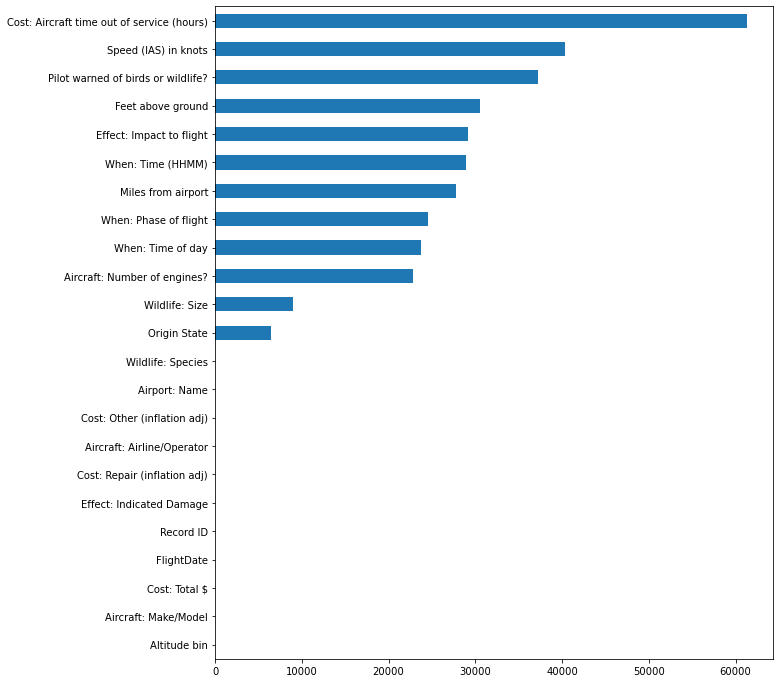

In [ ]:
data.isna().sum().sort_values().plot.barh(figsize=(10,12));

## Categorical Data

Let's look for categorical values. We can assume that categorical data has way fewer unique values than a column's total values. It's trivial to automate that assumption.

In [ ]:
#export

def findCategoricalCandidates(data:pd.DataFrame, ratio:float=0.01)->pd.DataFrame:
    result = pd.DataFrame(
        [(col, len(data[col].unique())) for col in data.columns],
        columns=['name', 'size']
    ).sort_values(by='size')
    
    n = len(data)
    return result[result['size'] / n < ratio]

For each categorical candidate, we'd like to have a tally for each possible category. This can show us problematic categories but also indicates columns that can be readily used for groupby/pivot tables. I use pd.DataFrame as a result type mainly for improved readability but also because it feels as if I was building my own database catalogue.

In [ ]:
#export

def categoricalTally(data:pd.DataFrame, cat_candidates:list, limit:int=10)->pd.DataFrame:
    result_cols = ['column'] + [f'cat{i:02d}' for i  in range(limit)]
    result = pd.DataFrame(columns=result_cols)
    
    index = 0
    for col in cat_candidates:    
        categories = data[col].unique()[:limit]
        result.loc[index] = ([col] + [(cat, len(data[data[col] == cat])) for cat in categories]
                                   + [None for i in range(len(categories), limit)])
        index += 1
        
    return result

In [ ]:
categoricalTally(data, findCategoricalCandidates(data)['name'])

,column,cat00,cat01,cat02,cat03,cat04,cat05,cat06,cat07,cat08,cat09
0,Effect: Indicated Damage,"(No damage, 61535)","(Caused damage, 4075)",None,None,None,None,None,None,None,None
1,Altitude bin,"(< 1000 ft, 27523)","(Unknown, 30541)","(> 1000 ft, 7546)",None,None,None,None,None,None,None
2,Pilot warned of birds or wildlife?,"(nan, 0)","(Y, 13100)","(N, 15261)",None,None,None,None,None,None,None
3,Wildlife: Size,"(Medium, 18064)","(Large, 3416)","(Small, 35204)","(nan, 0)",None,None,None,None,None,None
4,When: Time of day,"(nan, 0)","(Day, 25269)","(Night, 13623)","(Dusk, 1759)","(Dawn, 1207)",None,None,None,None,None
5,Effect: Impact to flight,"(nan, 0)","(None, 33247)","(Aborted Take-off, 594)","(Precautionary Landing, 1767)","(Other, 812)","(Engine Shut Down, 96)",None,None,None,None
6,Aircraft: Number of engines?,"(2, 37127)","(1, 2114)","(4, 1068)","(nan, 0)","(3, 2456)","(S, 1)",None,None,None,None
7,When: Phase of flight,"(Climb, 6317)","(Take-off run, 7239)","(Landing Roll, 7304)","(Approach, 16914)","(nan, 0)","(Taxi, 126)","(Descent, 1261)","(En Route, 1533)","(Parked, 42)","(Landing, 315)"
8,Miles from airport,"(nan, 0)","(0, 34610)","(12, 77)","(13, 13)","(20, 172)","(3, 341)","(8, 127)","(5, 394)","(50, 10)","(7, 121)"
9,Origin State,"(Michigan, 1373)","(Wisconsin, 695)","(Tennessee, 2097)","(California, 5278)","(nan, 0)","(Prince Edward Island, 97)","(Ohio, 2297)","(Florida, 3634)","(Louisiana, 1409)","(Georgia, 1083)"


## Data Repair & Cleanup

In [ ]:
data.describe()

,Record ID,When: Time (HHMM)
count,65610.000000,36636.000000
mean,246208.681116,1389.074271
std,80226.508941,613.410508
min,9005.000000,0.000000
25%,240765.250000,915.000000
50%,257226.500000,1410.000000
75%,303635.750000,1930.000000
max,322935.000000,2359.000000


Only two non-object columns is not what we expected from this dataset. Let's fix the columns that were parsed as strings but should have been numerical instead.

In [ ]:
for col in ['Speed (IAS) in knots', 'Feet above ground', 'Cost: Other (inflation adj)',
            'Cost: Aircraft time out of service (hours)', 'Cost: Other (inflation adj)',
            'Cost: Repair (inflation adj)', 'Cost: Total $']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

In [ ]:
data.describe()

,Record ID,When: Time (HHMM),Cost: Aircraft time out of service (hours),Cost: Other (inflation adj),Cost: Repair (inflation adj),Cost: Total $,Feet above ground,Speed (IAS) in knots
count,65610.000000,36636.000000,4294.000000,65063.000000,64258.000000,64081.000000,26351.000000,25296.000000
mean,246208.681116,1389.074271,30.902422,2.069686,1.268745,2.786192,106.772912,144.463631
std,80226.508941,613.410508,102.120082,29.903886,26.112340,35.504005,199.300885,47.737767
min,9005.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,240765.250000,915.000000,0.000000,0.000000,0.000000,0.000000,0.000000,120.000000
50%,257226.500000,1410.000000,1.000000,0.000000,0.000000,0.000000,0.000000,140.000000
75%,303635.750000,1930.000000,10.000000,0.000000,0.000000,0.000000,100.000000,160.000000
max,322935.000000,2359.000000,984.000000,998.000000,984.000000,984.000000,995.000000,500.000000


The dataset uses its own values to fill in for missing data. It can be useful to just fold those into n/a values, so that Pandas knows how to deal with them, i.e, exlude them from groupby/crosstab.

In [ ]:
data[data['Airport: Name'] == 'UNKNOWN'] = None
data['Airport: Name'].isna().sum()

5998

We don't want the FAA's own record id to be accidentally used for correlation analysis, so we exclude the column by making it the dataset's index. The much easier fix would be to drop the column but that just feels wrong.

There are a couple missing record indices, so we'd expect `pd.DataFrame.set_index` to fail but pandas doesn't require the index to be unique. This can become problematic once you try to use data exchange formats such as `feather`. We fill up the missing indices with negative values. That way, we can still differentiate between original and synthetic record indices.

In [ ]:
def negativeCounter(start:int):
    count = start
    while True:
        yield count
        count -= 1

nc = negativeCounter(-1)

if data.index.name != 'Record ID':
    data.set_index('Record ID', inplace=True)
    data.index = data.index.map(lambda idx: next(nc) if pd.isna(idx) else int(idx))

data.index

Int64Index([227413, 226578, 268383, 229514, 225661, 230694, 234288, 231042,
                -1, 233011,
            ...
             -5987,  -5988,  -5989, 319982, 319981, 319591, 319983, 319593,
            319589, 319594],
           dtype='int64', name='Record ID', length=65610)

Let's also fix the `FlightDate`:

In [ ]:
data['FlightDate'] = pd.to_datetime(data['FlightDate'], infer_datetime_format=True)

## Correlation

As a first approach, a correlation matrix isn't going to produce much insight, simply because categorical columns are ignored in this analysis.

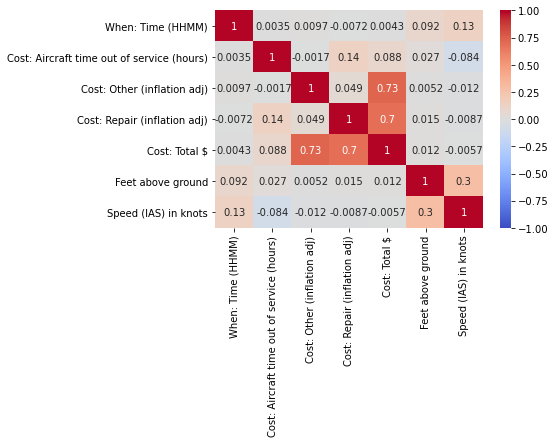

In [ ]:
sns.heatmap(data.corr(), cmap='coolwarm', annot=True, vmin=-1, vmax=1);

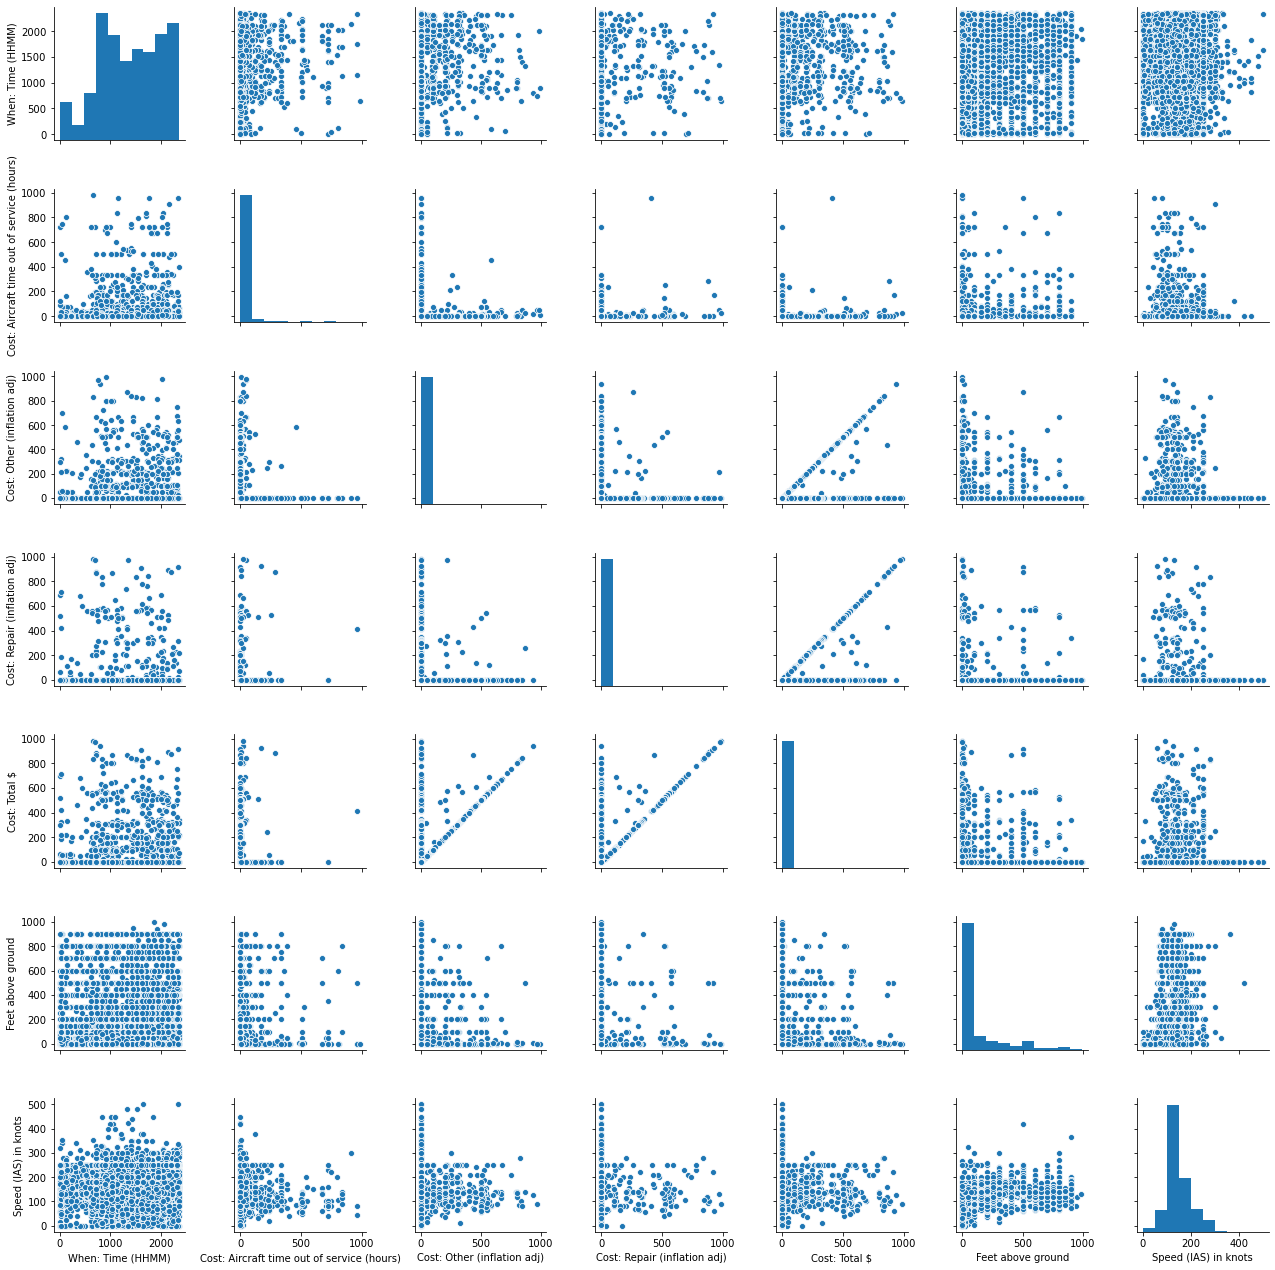

In [ ]:
sns.pairplot(data);

## Preliminary Analysis

We want to know what contributes to an increased risk of bird strikes. We have useful categorical data. Mainly we look for clustering in our data. After-the-fact data such as `Cost: Aircraft time out of service (hours)` can be safely ignored. `Effect: {Impact to flight, Indicated Damage}` can be seen as our target variables, to a degree. We can imagine multiple factors influencing the result:

* regionality: wildlife prefers some region over others,
* aircraft make/model: A Cesna is probably more affected by bird strikes than a Boeing 747,
* number of engines: Purely from a redundancy standpoint, more engines is likely to be better,
* altitude: birds fly at certain heights,
* altitude: aircraft could be more vulnerable at certain heights, with lower altitudes probably being riskier,
* time of day: wildlife has behavioural patterns,
* airline operators: some airline operators might service their aircrafts better than others, or use more reliable models,
* ...

Not all of the above mentioned factors increase the risk of a bird strike, however. In that sense, we can use the effect columns as indicators but not as final result. Also, the [FAA compiled a FAQ](https://www.faa.gov/airports/airport_safety/wildlife/faq/) that could help us understand the data. The [FAA's form to report bird strikes](https://wildlife.faa.gov/add) can give us clues as to why columns might have bad or unreliable data. 

## Data Imputation & Feature Engineering

### Time of Day
Querying by time/time of day is problematic due to the high percentage of missing data.

In [ ]:
data[['When: Time of day', 'When: Time (HHMM)']].isna().sum() / len(data)

When: Time of day    0.396037
When: Time (HHMM)    0.457186
dtype: float64

We can attempt to fix missing time of day data by using the airport's distribution of flights over the day and apply that distribution to the missing data. Not every record carries an airport name, so this won't fix all records wrt. time of day. We exploit how [pd.qcut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html) distributes records among its categories, meaning that once we know our probabilities for a given airport, we can select one of the `When: cat` columns in our crosstable and generate a `When: Time (HHMM)` entry.

In [ ]:
#export
def timeOfDay(time_iv: pd.Interval)->str:
    if not isinstance(time_iv, pd.Interval):
        return None
    
    if (time_iv.left >= 2200 and time_iv.right < 2400) or (time_iv.left > 0 and time_iv.right < 400):
        return 'Night'
    
    if time_iv.left >= 400 and time_iv.right < 600:
        return 'Dawn'
    
    if time_iv.left >= 2000 and time_iv.right < 2200:
        return 'Dusk'
    
    return 'Day'

*The next code cell takes a while to compute, it's at least 3 nested loops, with quite a few memory allocations!*

In [ ]:
data['When: cat'] = pd.qcut(data['When: Time (HHMM)'], 24)
data_tod = data.copy()
tod_ct = pd.crosstab(data_tod['Airport: Name'], data_tod['When: cat'], margins=True)
tod_na = data_tod[data_tod['When: Time (HHMM)'].isna()]

for idx in tod_ct[:-1].index:
    row = tod_ct.loc[idx]
    total = row['All']
    prob = [i / total for i in row[:-1]]
    to_fix = tod_na.loc[tod_na['Airport: Name'] == idx]
    
    for idx_to_fix in to_fix.index:
        tod_interval = np.random.choice(tod_ct.columns[:-1], p=prob)
        mt_hours = np.random.randint(tod_interval.left, tod_interval.right) // 100 * 100
        mt_minutes = np.random.randint(tod_interval.left, tod_interval.right) % 60 # only an approximation, not the correct way to do it
        data_tod.loc[idx_to_fix, ['When: Time (HHMM)', 'When: cat', 'When: Time of day']] = (mt_hours + mt_minutes, tod_interval, timeOfDay(tod_interval))


In [ ]:
data_tod[['When: Time of day', 'When: Time (HHMM)', 'When: cat']].isna().sum() / len(data)

When: Time of day    0.109770
When: Time (HHMM)    0.094041
When: cat            0.094041
dtype: float64

### Aircraft: Make/Model &rarr; UNKNOWN

 `UNKNOWN` aircraft at `unknown` altitude can be missing data but probably also covers military aircrafts. Let's fix those `UNKNOWN` near to known military bases or mentioning a military operator to 'MIL. AIRCRAFT'. The remaining `UNKNOWN`s we can set to `None`.

In [ ]:
pred_mil_ac = (data_tod['Aircraft: Make/Model'] == 'UNKNOWN') & (
    data_tod['Aircraft: Airline/Operator'] == 'MILITARY')
pred_mil_ap = (data_tod['Aircraft: Make/Model'] == 'UNKNOWN') & (
    data_tod['Airport: Name'].isin(['DENVER INTL AIRPORT', 'DALLAS/FORT WORTH INTL ARPT']))

In [ ]:
data_tod.loc[pred_mil_ac, 'Aircraft: Make/Model'] = 'MIL. AIRCRAFT'
data_tod.loc[pred_mil_ap, 'Aircraft: Make/Model'] = 'MIL. AIRCRAFT'
data_tod.loc[data_tod['Aircraft: Make/Model'] == 'UNKNOWN', 'Aircraft: Make/Model']  = None

## Save/Load functionality

Let's save the current state of our model so we can continue from here in a new notebook. Pickle was the only export format that worked properly; both feather and parquet tripped over trivial problems with the dataframe.

In [ ]:
#export
def filename(name:str)->Path:
    return (Path().absolute() / 'models' / name).with_suffix('.pickle')

def save(data:pd.DataFrame, name:str):
    fn = filename(name)
    fn.parent.mkdir(parents=True, exist_ok=True)
    data.to_pickle(fn)
        
def load(name:str)->pd.DataFrame:
    fn = filename(name)
    return pd.read_pickle(fn) #, low_memory=False, parse_dates=True)

In [ ]:
save(data_tod, 'bird-strikes')

The [analysis & visualization](/sully/analysis/) follows in the next notebook.